# Watershed Image Segmentation with OpenCV

**Goal**: Learn about **marker-based watershed** segmentation in OpenCV.
1. 이론: watershed 알고리즘 (topographic 접근, 물 채우기 + 장벽)
2. 단계:
   - **전경/배경 분할**(전처리)
   - **마커(marker) 생성** (foreground labels / background label / unknown=0)
   - **`cv.watershed(img, markers)`** 적용 → 결과에서 **경계 = -1**
3. 예시: 동전 이미지에서 서로 붙어 있는 동전 분할
4. 과제 & 확장


# 1. Colab 준비 (라이브러리 설치)

In [ ]:
!pip install opencv-python numpy matplotlib --quiet
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
print("OpenCV version:", cv.__version__)

OpenCV version: 4.10.0


## 동전 이미지 다운로드 (OpenCV sample) 또는 다른 이미지 사용 가능

In [ ]:
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/data/coins.png -O coins.png
import os

if not os.path.exists('coins.png'):
    print("coins.png download failed. Please upload an image named 'coins.png' or change path.")
else:
    print("coins.png is ready.")

coins.png is ready.


# 2. 이론 요약: Watershed 알고리즘
1. **Topographic surface**: 픽셀 밝기를 높이로 해석.
2. 물을 골짜기(어두운 부분)부터 채우기 시작. 골짜기마다 색깔이 다름.
3. 물이 올라가면서 만나는 경계 지점에 **장벽** 형성.
4. 최종 장벽이 세그멘테이션 경계.

### 문제: Over-segmentation
- 작은 노이즈도 새 골짜기로 인식.
- 해결: **marker-based watershed** → 우리가 전경/배경 확실한 부분을 먼저 레이블

### 알고리즘 순서
1. **Threshold**(이진화), **Morphology**로 **sure foreground**(전경)와 **sure background**(배경) 확정.
2. **unknown region** = bg - fg
3. `cv.connectedComponents`로 전경에 라벨 부여.
4. 배경에 +1해서 1이상.
5. 미지영역=0.
6. `cv.watershed(img, markers)` → marker의 -1이 경계.


# 3. Watershed 단계별 예제
아래 코드는 **coins.png** 이미지를 **marker-based watershed**로 분할.

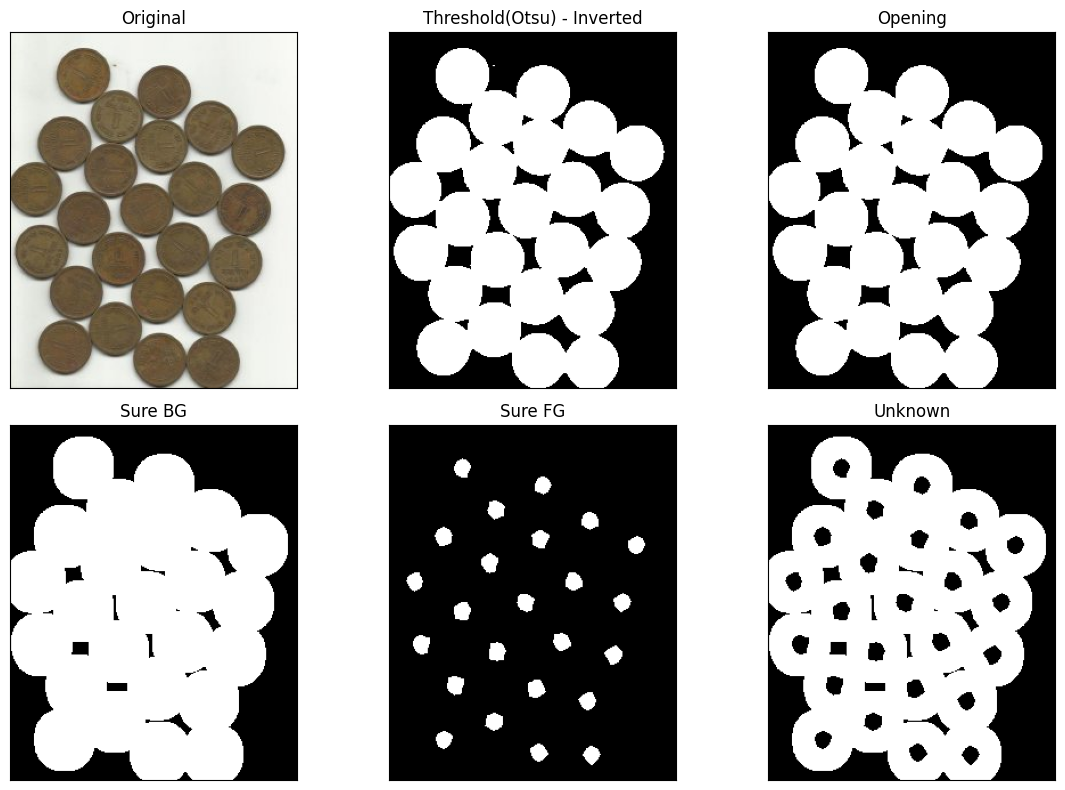

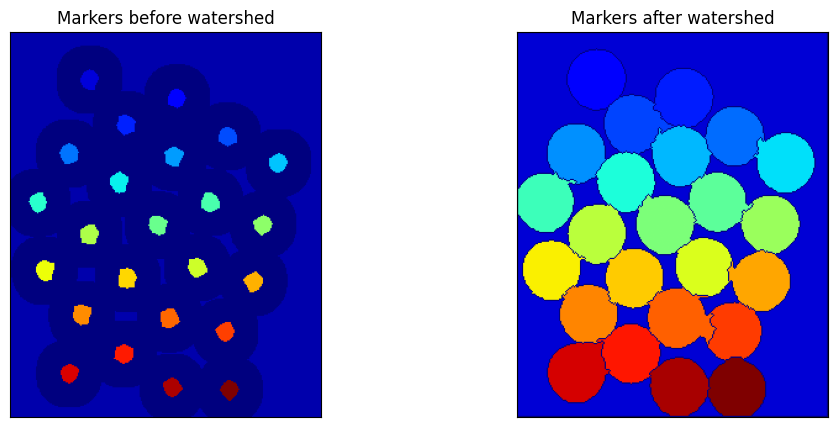

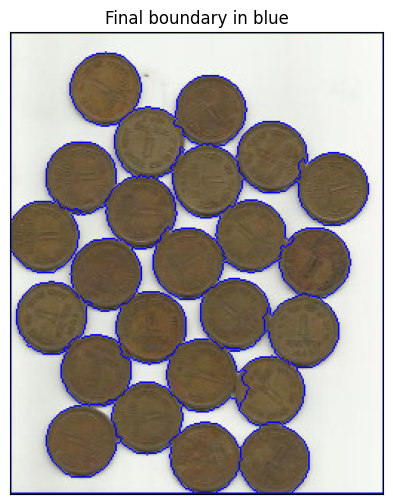

In [ ]:
img = cv.imread('coins.png')
if img is None:
    raise FileNotFoundError("coins.png not found.")

# 1) 그레이 & 이진화(거꾸로) -> Otsu
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# 2) 노이즈 제거: Morphology opening
kernel = np.ones((3,3), np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)

# 3) sure background: dilation
sure_bg = cv.dilate(opening, kernel, iterations=3)

# 4) sure foreground: distance transform + threshold
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
dist_max = dist_transform.max()
ret, sure_fg = cv.threshold(dist_transform, 0.7*dist_max, 255, 0)

# 5) unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

# 6) marker labeling
ret, markers = cv.connectedComponents(sure_fg)
# background label = 0, so we do +1 so background=1
markers = markers + 1
# unknown region = 0
markers[unknown==255] = 0

# 7) watershed
markers_ws = markers.copy()
cv.watershed(img, markers_ws)

# 경계 부분은 -1로 표시됨. 경계 픽셀을 (255,0,0)로 칠하기
img_ws = img.copy()
img_ws[markers_ws == -1] = [255, 0, 0]

# 시각화
plt.figure(figsize=(12,8))
plt.subplot(2,3,1), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,2), plt.imshow(thresh, cmap='gray')
plt.title('Threshold(Otsu) - Inverted'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,3), plt.imshow(opening, cmap='gray')
plt.title('Opening'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,4), plt.imshow(sure_bg, cmap='gray')
plt.title('Sure BG'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,5), plt.imshow(sure_fg, cmap='gray')
plt.title('Sure FG'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,6), plt.imshow(unknown, cmap='gray')
plt.title('Unknown'), plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1), plt.imshow(markers, cmap='jet')
plt.title('Markers before watershed'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(markers_ws, cmap='jet')
plt.title('Markers after watershed'), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(cv.cvtColor(img_ws, cv.COLOR_BGR2RGB))
plt.title('Final boundary in blue'), plt.xticks([]), plt.yticks([])
plt.show()


# 4. 과제
1. **Distance Transform** 파라미터(마스크 크기=3 or 5 등) 바꿔보기.
2. **Threshold** 시, dist_transform에 `0.6~0.8 * dist_max` 범위를 조정해 본다.
3. **Erosion** 방식으로 sure_fg 구해보고, distanceTransform 방식과 비교.
4. **다른 이미지**(겹쳐 있는 물체)로 Watershed 적용.
5. **전경만** 구하면 될 경우, 굳이 distance transform까지 필요 없는 케이스(erosion만으로 가능)도 실습.


# Q&A
- **Q**: `markers`는 어떤 형식인가?
  - **A**: `markers`는 `int32` 배열. 서로 다른 정수 레이블.
- **Q**: Watershed 결과 경계는 어떻게?
  - **A**: `markers == -1`가 경계. 원하는 색으로 칠하면 시각화 가능.
- **Q**: 오버세그먼테이션을 더 줄이고 싶다면?
  - **A**: 전처리(블러, morphology) 강화, dist_transform threshold 조정, 또는 **외부**에서 더 큰 영역을 FG로 지정.
- **Q**: Watershed 알고리즘 복잡도?
  - **A**: 고전적 최단경로 기반 알고리즘. 구현은 복잡하지만, OpenCV가 최적화된 `cv.watershed` 제공.

이상으로 **marker-based watershed** 알고리즘을 Colab에서 실습했습니다.
추가 과제를 통해 다양한 이미지와 파라미터를 시도해 보세요!